In [ ]:
!sudo apt-get install tree -qq > /dev/null

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


In [ ]:
!pip install torch
!pip install numpy
!pip install PyYAML
!pip install git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-8lcqpikw
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-8lcqpikw
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263917 sha256=ac5263262de98f46d28968eabc8bc0f9360874e68760a1457d32c9411cc332ae
  Stored in directory: /tmp/pip-ephem-wheel-cache-eu9c6vij/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0.2
    Uninstalling pycocotools-2.0.2:
      Successfully uninstalled pycocotools-2.0.2


In [ ]:
import zipfile
import os
import time

from google.colab import drive
from PIL import Image, ImageDraw

from pathlib import Path
from tqdm import tqdm
import numpy as np
import json
import urllib
import PIL.Image as Image
import cv2
import torch
import torchvision
from IPython.display import display
from sklearn.model_selection import train_test_split
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 16, 10
np.random.seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
zip_file = '/content/gdrive/MyDrive/data/faces/wider_face_dataset/WIDER_train.zip'
z = zipfile.ZipFile(zip_file, 'r')
z.extractall('/content/data/unprocessed/wider_face/')

In [ ]:
from google.colab import files 

In [ ]:
files.upload()

Saving wider_face_train_bbx_gt.txt to wider_face_train_bbx_gt.txt


{'wider_face_train_bbx_gt.txt': b'0--Parade/0_Parade_marchingband_1_849.jpg\n1\n449 330 122 149 0 0 0 0 0 0 \n0--Parade/0_Parade_Parade_0_904.jpg\n1\n361 98 263 339 0 0 0 0 0 0 \n0--Parade/0_Parade_marchingband_1_799.jpg\n21\n78 221 7 8 2 0 0 0 0 0 \n78 238 14 17 2 0 0 0 0 0 \n113 212 11 15 2 0 0 0 0 0 \n134 260 15 15 2 0 0 0 0 0 \n163 250 14 17 2 0 0 0 0 0 \n201 218 10 12 2 0 0 0 0 0 \n182 266 15 17 2 0 0 0 0 0 \n245 279 18 15 2 0 0 0 0 0 \n304 265 16 17 2 0 0 0 2 1 \n328 295 16 20 2 0 0 0 0 0 \n389 281 17 19 2 0 0 0 2 0 \n406 293 21 21 2 0 1 0 0 0 \n436 290 22 17 2 0 0 0 0 0 \n522 328 21 18 2 0 1 0 0 0 \n643 320 23 22 2 0 0 0 0 0 \n653 224 17 25 2 0 0 0 0 0 \n793 337 23 30 2 0 0 0 0 0 \n535 311 16 17 2 0 0 0 1 0 \n29 220 11 15 2 0 0 0 0 0 \n3 232 11 15 2 0 0 0 2 0 \n20 215 12 16 2 0 0 0 2 0 \n0--Parade/0_Parade_marchingband_1_117.jpg\n9\n69 359 50 36 1 0 0 0 0 1 \n227 382 56 43 1 0 1 0 0 1 \n296 305 44 26 1 0 0 0 0 1 \n353 280 40 36 2 0 0 0 2 1 \n885 377 63 41 1 0 0 0 0 1 \n819 391 3

In [ ]:
with open('/content/wider_face_train_bbx_gt.txt') as f:
  name = f.readline().strip()
  num_faces = int(f.readline())
  bbx = []
  for i in range(num_faces):
    bbx.append(f.readline().split())
  
  img = Image.open('/content/data/unprocessed/wider_face/WIDER_train/images/' + name)
  img_draw = img.copy()
  draw = ImageDraw.Draw(img_draw)
  for b in bbx:
    b = [int(bi) for bi in b]
    draw.rectangle([b[0], b[1], b[0] + b[2], b[1] + b[3]], outline=(255, 0, 0), width=2)


In [ ]:
def without_folder(name):
  parts = name.strip().split('/')
  return ''.join(parts[1:])

In [ ]:
print(name)
print(without_folder(name))
print(without_folder(name).split('.')[0] + '.txt')

0--Parade/0_Parade_marchingband_1_849.jpg
0_Parade_marchingband_1_849.jpg
0_Parade_marchingband_1_849.txt


In [ ]:
def process_wider_face(input_images_path, input_labels_path, dataset_type):
  images_path = Path(f"faces/images/{dataset_type}")
  images_path.mkdir(parents=True, exist_ok=True)

  labels_path = Path(f"faces/labels/{dataset_type}")
  labels_path.mkdir(parents=True, exist_ok=True)

  with open(input_labels_path) as f:
    j = 0
    while True:
      name = f.readline().strip()
      if name == '':
        break

      img = Image.open(input_images_path + name)
      img = img.convert('RGB')
      img.save(str(images_path / without_folder(name)), "JPEG")

      label_name = without_folder(name).split('.')[0] + '.txt'
      
      num_faces = int(f.readline())
      if num_faces > 0:
        with(labels_path / label_name).open(mode='w') as label_file:       
          w, h = img.size
          for i in range(num_faces):
            box = f.readline().split()
            x1, y1 = int(box[0]) / w, int(box[1]) / h
            bw, bh = int(box[2]) / w, int(box[3]) / h
            
            label_file.write(f"1 {x1 + bw / 2} {y1 + bh / 2} {bw} {bh}\n")
      else:
        empty_box = f.readline()
      
      # print(j, name)
      # j += 1

In [ ]:
process_wider_face(
    input_images_path='/content/data/unprocessed/wider_face/WIDER_train/images/',
    input_labels_path='/content/wider_face_train_bbx_gt.txt',
    dataset_type='train'
)

In [ ]:
def test_dataset():
  image = Image.open('faces/images/train/0_Parade_Parade_0_1019.jpg')

  img_draw = image.copy()
  draw = ImageDraw.Draw(img_draw)
  with open('faces/labels/train/0_Parade_Parade_0_1019.txt') as f:
    for box in f:
      box = box.strip().split()
      x, y, bw, bh = float(box[1]), float(box[2]), float(box[3]), float(box[4])
      w, h = image.size

      x1, y1 = (x - bw / 2) * w, (y - bh / 2) * h
      x2, y2 = x1 + bw * w, y1 + bh * h

      draw.rectangle([x1, y1, x2, y2], outline=(255, 0, 0), width=2)
  
  return img_draw

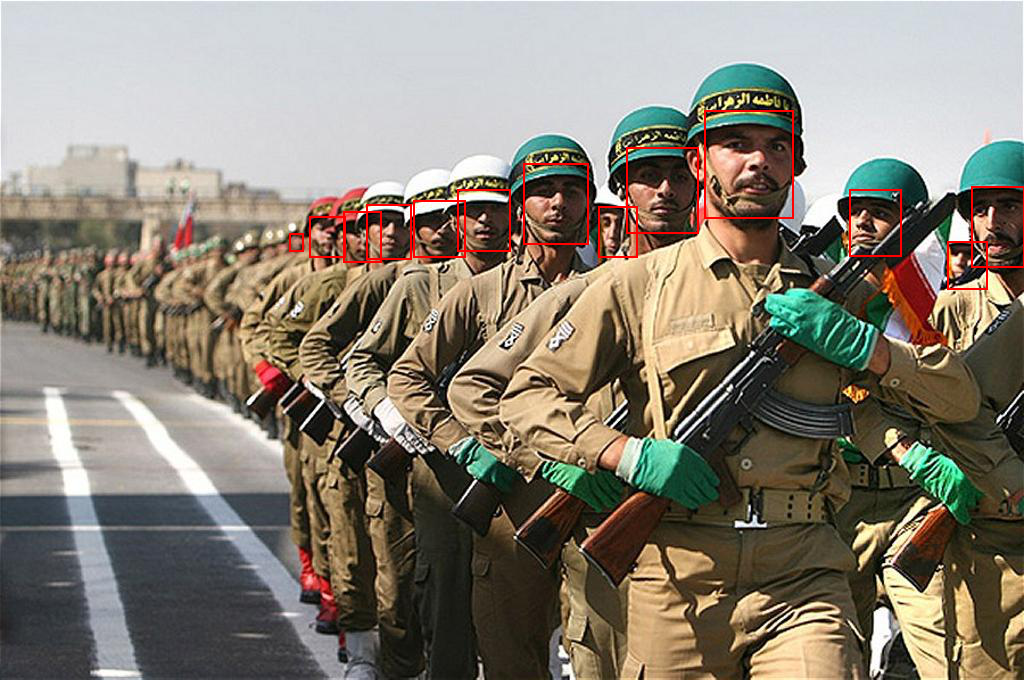

In [ ]:
test_dataset()

In [ ]:
import os, os.path

# simple version for working with CWD
print(len([name for name in os.listdir('faces/images/train')]))

12880


In [ ]:
!nvidia-smi

Mon Apr  5 07:35:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!nvidia-smi

Mon Apr  5 07:35:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
zip_file = '/content/gdrive/MyDrive/data/faces/wider_face_dataset/WIDER_val.zip'
z = zipfile.ZipFile(zip_file, 'r')
z.extractall('/content/data/unprocessed/wider_face/')

In [ ]:
process_wider_face(
    input_images_path='/content/data/unprocessed/wider_face/WIDER_val/images/',
    input_labels_path='/content/wider_face_val_bbx_gt.txt',
    dataset_type='val'
)

In [ ]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay          69G   44G   25G  65% /
tmpfs            64M     0   64M   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
shm             5.8G     0  5.8G   0% /dev/shm
tmpfs           6.4G   24K  6.4G   1% /var/colab
/dev/sda1        75G   46G   30G  61% /opt/bin
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive            15G  392M   15G   3% /content/gdrive


In [ ]:
!zip -r '/content/gdrive/MyDrive/data/faces/wider_face_darknet.zip' '/content/faces'

Выходные данные были обрезаны до нескольких последних строк (5000).
  adding: content/faces/labels/train/17_Ceremony_Ceremony_17_402.txt (deflated 70%)
  adding: content/faces/labels/train/57_Angler_peoplefishing_57_592.txt (deflated 23%)
  adding: content/faces/labels/train/12_Group_Large_Group_12_Group_Large_Group_12_38.txt (deflated 71%)
  adding: content/faces/labels/train/20_Family_Group_Family_Group_20_319.txt (deflated 59%)
  adding: content/faces/labels/train/5_Car_Accident_Accident_5_127.txt (deflated 45%)
  adding: content/faces/labels/train/35_Basketball_basketballgame_ball_35_120.txt (deflated 62%)
  adding: content/faces/labels/train/12_Group_Group_12_Group_Group_12_24.txt (deflated 72%)
  adding: content/faces/labels/train/37_Soccer_Soccer_37_572.txt (deflated 21%)
  adding: content/faces/labels/train/12_Group_Group_12_Group_Group_12_130.txt (deflated 60%)
  adding: content/faces/labels/train/12_Group_Team_Organized_Group_12_Group_Team_Organized_Group_12_905.txt (deflated

In [ ]:
zip_file = '/content/gdrive/MyDrive/data/faces/wider_face_darknet.zip'
z = zipfile.ZipFile(zip_file, 'r')
z.extractall('/content/temp/')

In [ ]:
imgs = []
bad_face_count = 0
total_face_count = 0
with open('/content/wider_face_train_bbx_gt.txt') as f:
    for im in range(100):
        name = f.readline().strip()
        num_faces = int(f.readline())
        bbx = []
        for i in range(num_faces):
            bbx.append(f.readline().split())
        
        img = Image.open('/content/data/unprocessed/wider_face/WIDER_train/images/' + name)
        img_draw = img.copy()
        draw = ImageDraw.Draw(img_draw)
        for b in bbx:
            b = [int(bi) for bi in b]
            outline = (255, 0, 0) if b[-1] == 1 else (0, 255, 0)
            bad_face_count += b[-1]
            total_face_count += 1
            draw.rectangle([b[0], b[1], b[0] + b[2], b[1] + b[3]], outline=outline, width=2)
        imgs.append(img_draw)


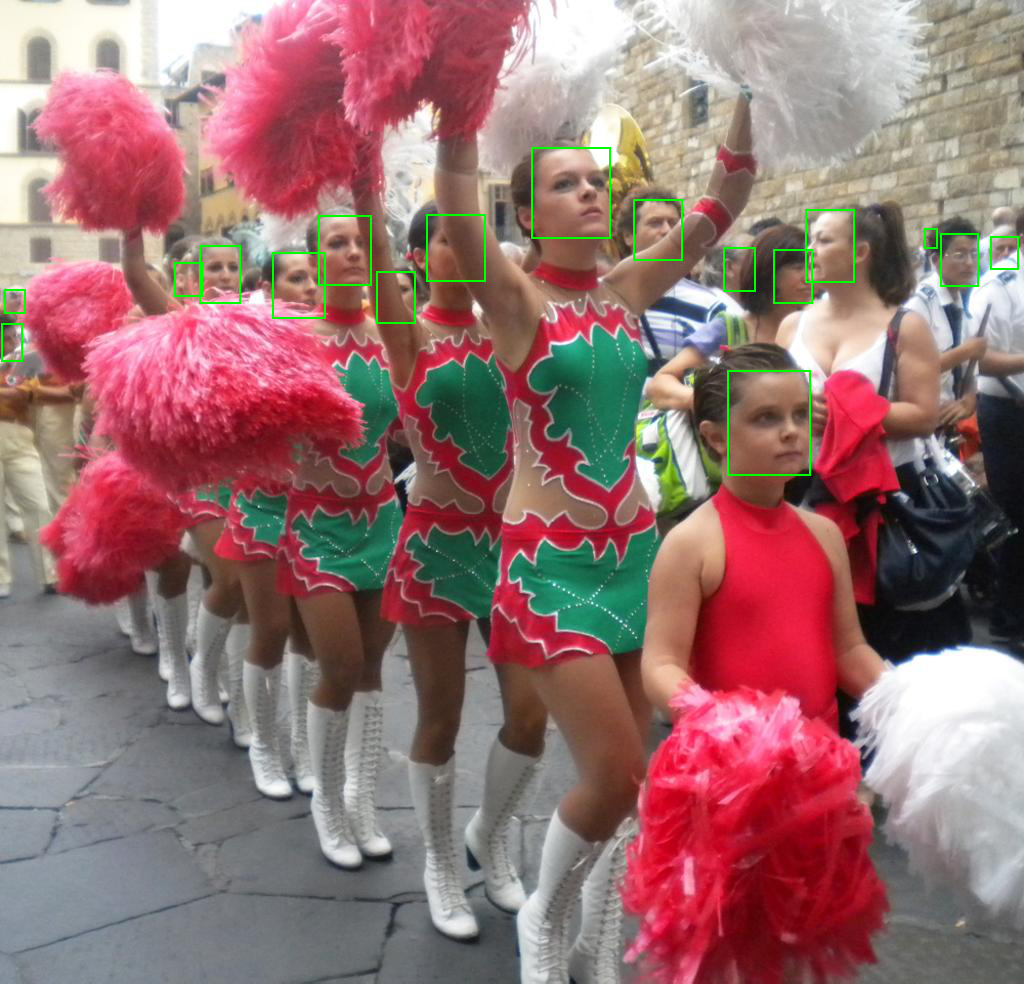

In [ ]:
imgs[97]

In [ ]:
bad_face_count, total_face_count

(162, 3777)